# Autoencoders

Consider the spaces $\mathcal{X}$ as the data space and $\mathcal{Z}$ as the latent space.

Consider the functions $E: \mathcal{X}\to\mathcal{Z}$ and $D: \mathcal{Z}\to\mathcal{X}$.

An autoencoder __encodes data in a latent-space__ minimizing the reconstruction error.

<img src="https://miro.medium.com/max/1200/1*ViBG49eTCKqqO2UVRL9mEw.png" width="500px"/>

It is composed by:

- encoder (E): encodes the data in the latent-space (as a *code*);
- decoder (D): reconstructs the data from the latent-space representation.

Depending on the code size:

- __undercomplete__: dimensionality reduction, classical case;
- __overcomplete__: code bigger, without additional constraints the identity funciton is learned.

The objective is generating an output as close as possible to the input.

One immediate choice for the loss is MSE:

$$\Large
\mathcal{L}(\{x,\hat{x}\}) = \sum_i \|x_i-\hat{x}_i\|^2
$$

In case of linear activations:

$$\large
\begin{eqnarray}
z &=& E(x) = W_E x + b_E \\
\hat{x} &=& D(z) = W_D z + b_D \\
        &=& W_D W_E x + W_D b_E + b_D \\
        &=& W_{AE} x + b_{AE} \\
\end{eqnarray}
$$

representing just a linear transformation with bias.

# Deep convolutional autoencoders

Deep is.. deep:

<img src="https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width="500px"/>

Every block is convolutional (with activation).

In [1]:
# Just to work comfortably with py files:
%load_ext autoreload
%autoreload 2

## Convolutional autoencoders

Convolution is the base operation both in encoding and decoding.

Let's create one that encodes MNIST digits.

Train samples: 60000
Test samples: 10000


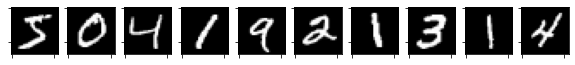

In [2]:
from plotting import plot_images
from dataset import load_mnist, PairDataset

# Mnist dataset:
mnist_train = load_mnist(train=True)[0]
train_ds = PairDataset(mnist_train)
print(f"Train samples: {len(train_ds)}")

mnist_test = load_mnist(train=False)[0]
test_ds = PairDataset(mnist_test)
print(f"Test samples: {len(test_ds)}")

# Showing some digits:
plot_images(mnist_train[0:10,:,:]);

### The convolutional autoencoder

In [3]:
from autoencoders import Encoder, Decoder, Autoencoder
from modules import num_params

enc = Encoder()
t_in = mnist_train[0:4,None,:,:]
t_code = enc(t_in)
print(f"Encoder:\n\tshapes: {tuple(t_in.shape)} => {tuple(t_code.shape)}")
print(f"\tparameters: {num_params(enc)}\n")

dec = Decoder()
t_out = dec(t_code)
print(f"Decoder:\n\tshapes: {tuple(t_code.shape)} => {tuple(t_out.shape)}")
print(f"\tparameters: {num_params(dec)}\n")

ae = Autoencoder()
t_out = ae(t_in)
print(f"Autoencoder:\n\tshapes:{tuple(t_in.shape)} => {tuple(t_out.shape)}")
print(f"\tparameters: {num_params(ae)}")

Encoder:
	shapes: (4, 1, 28, 28) => (4, 32, 1, 1)
	parameters: 26368

Decoder:
	shapes: (4, 32, 1, 1) => (4, 1, 28, 28)
	parameters: 26337

Autoencoder:
	shapes:(4, 1, 28, 28) => (4, 1, 28, 28)
	parameters: 52705


### Training the autoencoder

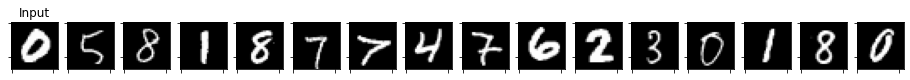

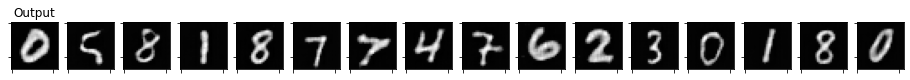

train_loss[1] = 0.0178043396760231
test_loss[1] = 0.010750467390723668



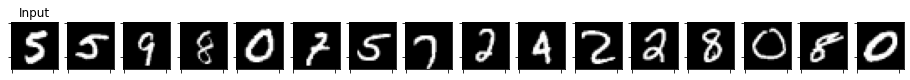

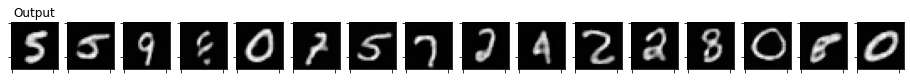

train_loss[2] = 0.009905611360465477
test_loss[2] = 0.009232732760986894



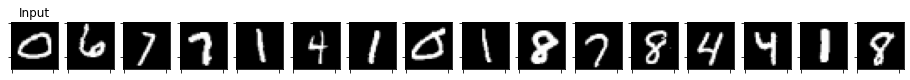

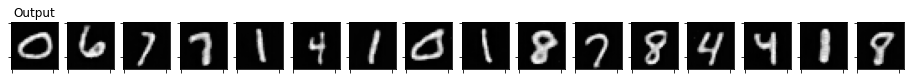

train_loss[3] = 0.009013271967528947
test_loss[3] = 0.008605107098556818



In [4]:
from training import train
from torch.nn import MSELoss

ae, metrics_ae = train(train_ds, test_ds, Autoencoder(), MSELoss(), epochs=3)

In [5]:
from training import save_model
save_model('models/ae', ae, metrics_ae)

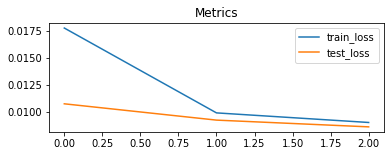

In [2]:
from training import load_model
from autoencoders import Autoencoder
ae, metrics_ae = load_model('models/ae', Autoencoder())
metrics_ae.plot()

## Denoising autoencoders

Denoising autoencoders are autoencoders trained to output cleaned samples given noisy samples in input.

They learn a __noise correction vector space__:

<img src="https://qph.cf2.quoracdn.net/main-qimg-cf9f1903c8a7720722769ad831ee3cf1" width="500"/>

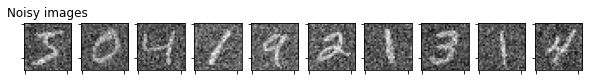

In [7]:
from dataset import corrupt

mnist_train_noisy = corrupt(mnist_train)
dtrain_ds = PairDataset(mnist_train_noisy, mnist_train)

mnist_test_noisy = corrupt(mnist_test)
dtest_ds = PairDataset(mnist_test_noisy, mnist_test)

plot_images(mnist_train_noisy[0:10,:,:], "Noisy images");

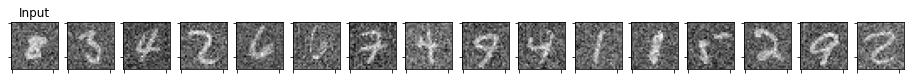

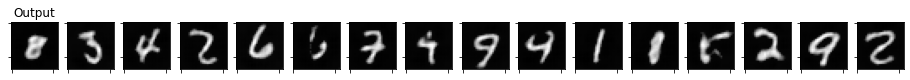

train_loss[1] = 0.020105204594605512
test_loss[1] = 0.012574020939268125



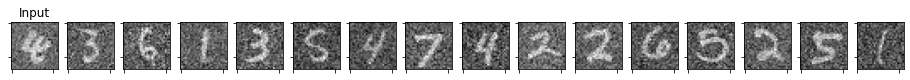

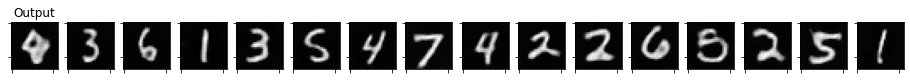

train_loss[2] = 0.012386454589990601
test_loss[2] = 0.01225327213360056



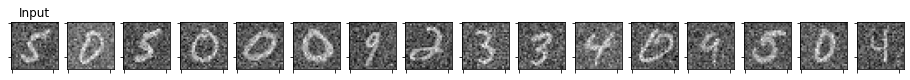

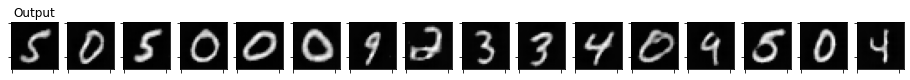

train_loss[3] = 0.011693643692976185
test_loss[3] = 0.011363505243448315



In [8]:
from training import train
from torch.nn import MSELoss

dae, metrics_dae = train(dtrain_ds, dtest_ds, Autoencoder(), MSELoss(), epochs=3)

In [9]:
from training import save_model
save_model('models/dae', dae, metrics_dae)

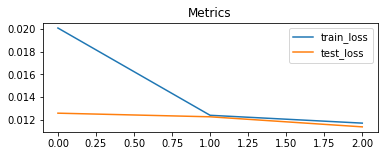

In [10]:
from training import load_model
dae, metrics_dae = load_model('models/dae', Autoencoder())
metrics_dae.plot()

## Data generation

What if we wish to generate data using the decoder only?

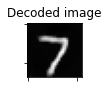

In [11]:
from torch import no_grad

# Splitting the model:
encoder = dae[0]
decoder = dae[1]

def gnerate_and_plot(encoded):
    with no_grad():
        # Decoding it:
        decoded = decoder(encoded)[:,0,:,:]

        # Is this process ok?
        plot_images(decoded, "Decoded image");
    
# Encoding and plotting one image:
encoded = encoder(mnist_test_noisy[0:1,None,:,:])
gnerate_and_plot(encoded)

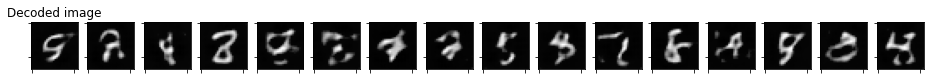

In [12]:
from torch import mean, std, tensor
import numpy as np

with no_grad():
    # Estimating the normal parameters (diagonal covariance):
    encoded_test = encoder(mnist_test_noisy[0:256,None,:,:])
    enc_mean = mean(encoded_test, dim=0)[None,:,:,:]
    enc_std = std(encoded_test, dim=0)[None,:,:,:]
    
    # Generating a random encoding:
    z = np.random.randn(16,*enc_mean.shape[1:]).astype(np.float32)
    encoded = tensor(z) * enc_std + enc_mean
    
    # Decoding and plotting:
    gnerate_and_plot(encoded)

## The embedding distribution is not (granted) gaussian

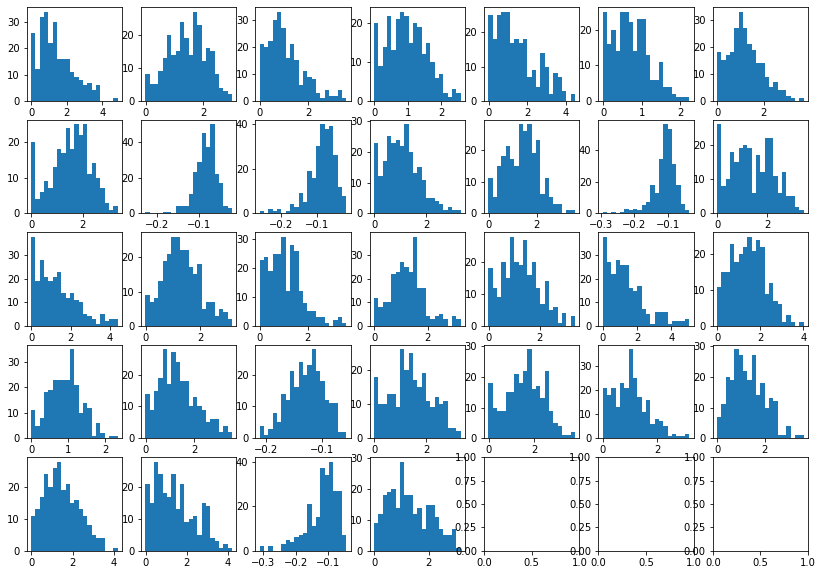

In [13]:
from plotting import plot_byvar_hist

plot_byvar_hist(encoded_test[:,:,0,0])

### Play around

- We are encoding digits in 32 numbers,  
  try encoding them in 16/64 values and check the difference.
- We are not using convolutions separated in depthwise + pointwise,  
  try using them and check the difference in #parameters and results.